In [1]:
import tqdm
import numpy as np
from pathlib import Path
from typing import Literal
import torchvision
from torchvision.transforms import v2 as tv2
import matplotlib.pyplot as plt
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data

In [2]:
data_dir = Path("data")
imgs_dir = data_dir / "things-eeg2-imgs"
eeg_dir = data_dir / "things-eeg2-pre"


ex_data_path = "data/things-eeg2-pre/sub-01/preprocessed_eeg_training.npy"
ex_data = np.load(ex_data_path, allow_pickle=True).item()
ex_data.keys()

dict_keys(['preprocessed_eeg_data', 'ch_names', 'times'])

In [3]:
train_img_paths = [
    img_dir
    for concept_dir in sorted((imgs_dir / "training_images").iterdir())
    for img_dir in sorted(concept_dir.iterdir())
]
test_img_paths = [
    img_dir
    for concept_dir in sorted((imgs_dir / "test_images").iterdir())
    for img_dir in sorted(concept_dir.iterdir())
]

train_imgs_per_concept = 10
test_imgs_per_concept = 1

In [4]:


def idx_to_img_path(idx: int, split: Literal["train", "test"]) -> Path:
    if split == "train":
        paths = train_img_paths

    elif split == "test":
        paths = test_img_paths

    else:
        raise ValueError(f"Invalid split: {split}")

    return paths[idx]


print("0", idx_to_img_path(0, "train"))  # Aardvark 1
print("10", idx_to_img_path(10, "train"))  # Acabus 1
print("11", idx_to_img_path(11, "train"))  # Acabus 2

0 data/things-eeg2-imgs/training_images/00001_aardvark/aardvark_01b.jpg
10 data/things-eeg2-imgs/training_images/00002_abacus/abacus_01b.jpg
11 data/things-eeg2-imgs/training_images/00002_abacus/abacus_02s.jpg


## Image Data

Size: torch.Size([3, 500, 500])
Dtype: torch.uint8
Min Max: tensor(6, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


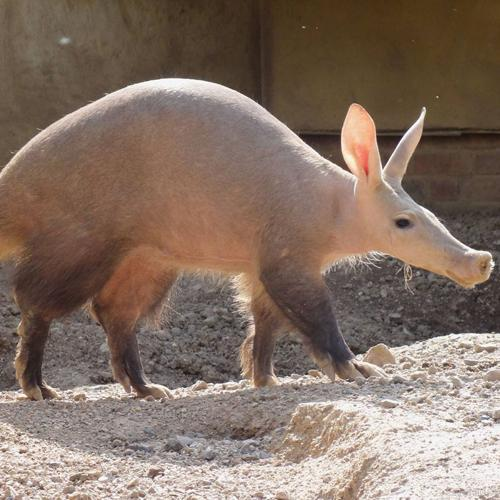

In [5]:

def load_img(idx: int, split: Literal["train", "test"]):
    path = idx_to_img_path(idx, split)
    img = torchvision.io.decode_image(str(path))
    return img


img = load_img(0, "train")

print("Size:", img.size())
print("Dtype:", img.dtype)
print("Min", "Max:", img.min(), img.max())

tv2.functional.to_pil_image(img)

Size: torch.Size([3, 224, 224])
Dtype: torch.float32
Min Max: tensor(0.0353) tensor(1.)


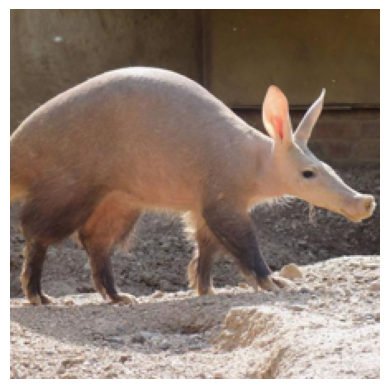

In [6]:
def preprocess_img(img: torch.Tensor) -> torch.Tensor:
    img = tv2.functional.resize(img, [224, 224], interpolation=tv2.InterpolationMode.BICUBIC)
    img = img / 255.0
    return img


img_pp = preprocess_img(img)
print("Size:", img_pp.size())
print("Dtype:", img_pp.dtype)
print("Min", "Max:", img_pp.min(), img_pp.max())

plt.imshow(img_pp.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

In [7]:
from dreamsim.model import dreamsim
from dreamsim.feature_extraction.load_synclr_as_dino import load_synclr_as_dino


dreamsim_model, _ = dreamsim(dreamsim_type="synclr_vitb16")
dreamsim_model.requires_grad_(False)
dreamsim_model.eval()
aligned_synclr_model = dreamsim_model.base_model.model.extractor_list[0].model


synclr_model = load_synclr_as_dino(16)
synclr_model.requires_grad_(False)
synclr_model.eval()

...;

Using cached ./models


/home/gasparyanartur/dev/brain-image-implementation/.venv/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [8]:
GEN_EMBEDDINGS = False


def gen_embeddings(
    model: torch.nn.Module,
    img_paths: list[Path],
    split: Literal["train", "test"],
    batch_size: int = 8,
    device: torch.device = device,
) -> np.ndarray:
    """Generate embeddings for a given split of images."""
    model.eval()
    model.to(device)
    embeddings = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, len(img_paths), batch_size)):
            imgs = [
                load_img(j, split=split)
                for j in range(i, min(i + batch_size, len(img_paths)))
            ]
            imgs = [preprocess_img(img).unsqueeze(0) for img in imgs]
            imgs = torch.cat(imgs, dim=0).to(device)
            emb = model(imgs)
            embeddings.append(emb.cpu().numpy())
    return np.concatenate(embeddings, axis=0)


embed_dir = data_dir / "things-eeg2-imgs-embed"
for model, name in [
    (synclr_model, "synclr"),
    (aligned_synclr_model, "aligned_synclr"),
]:
    if GEN_EMBEDDINGS:
        print(f"Generating {name} embeddings...")

        train_embeddings = gen_embeddings(
            model, train_img_paths, split="train", batch_size=512
        )
        np.save(f"{embed_dir / name}/train_embeddings.npy", train_embeddings)

        test_embeddings = gen_embeddings(
            model, test_img_paths, split="test", batch_size=512
        )
        np.save(f"{embed_dir / name}/test_embeddings.npy", test_embeddings)

    else:
        print("Loading embeddings...")

        train_embeddings = np.load(f"{embed_dir / name}/train_embeddings.npy")
        test_embeddings = np.load(f"{embed_dir / name}/test_embeddings.npy")

Loading embeddings...
Loading embeddings...


## EEG Data

In [9]:
channel_names = ex_data["ch_names"]
print(f"Channel names: {', '.join(channel_names)}")

eeg_data = ex_data["preprocessed_eeg_data"]
print("EEG data: ")
print(f"\tShape: {eeg_data.shape}")
print(f"\tData type: {eeg_data.dtype}")
print(f"\tMaximum value: {np.max(eeg_data)}")
print(f"\tMinimum value: {np.min(eeg_data)}")
print(f"\tMean value: {np.mean(eeg_data)}")
print(f"\tStandard deviation: {np.std(eeg_data)}")

times = ex_data["times"]
print(f"Times: {times}")

Channel names: Pz, P3, P7, O1, Oz, O2, P4, P8, P1, P5, PO7, PO3, POz, PO4, PO8, P6, P2
EEG data: 
	Shape: (16540, 4, 17, 100)
	Data type: float64
	Maximum value: 85.14618876376869
	Minimum value: -328.7584416400444
	Mean value: -0.03503607400085798
	Standard deviation: 0.8400870602744809
Times: [-0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09
 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03
  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15
  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27
  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39
  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  0.5   0.51
  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63
  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71  0.72  0.73  0.74  0.75
  0.76  0.77  0.78  0.79]


In [10]:
def preprocess_eeg_data(eeg_data):
    """Preprocess the EEG data by averaging over the number of repetitions.

    Args:
        eeg_data (numpy.ndarray): The EEG data to preprocess. <concepts, repetitions, channels, timesteps>

    Returns:
        numpy.ndarray: The preprocessed EEG data. <concepts, channels, timesteps>
    """
    # Average over the number of repetitions
    preprocessed_data = np.mean(eeg_data, axis=1).astype(np.float32)
    return preprocessed_data


eeg_data_pp = preprocess_eeg_data(eeg_data)
eeg_data_pp.shape

(16540, 17, 100)

In [11]:
def load_eeg_data(eeg_path: Path):
    """Load EEG data from a given path."""
    eeg_data = np.load(eeg_path, allow_pickle=True).item()
    return (
        preprocess_eeg_data(eeg_data["preprocessed_eeg_data"]),
        eeg_data["times"],
        eeg_data["ch_names"],
    )


def load_all_eeg_data(
    eeg_paths: list[Path],
) -> tuple[torch.Tensor, torch.Tensor, list[str]]:
    all_eeg_data = []
    all_times = None
    all_ch_names = []

    for eeg_path in eeg_paths:
        eeg_data, times, ch_names = load_eeg_data(eeg_path)
        all_eeg_data.append(torch.from_numpy(eeg_data))

        if all_times is None:
            all_times = torch.tensor(times)

        if not all_ch_names:
            all_ch_names = ch_names

    if all_times is None:
        all_times = torch.tensor([])

    return torch.concat(all_eeg_data), all_times, all_ch_names

## Unified Data

In [12]:
from pydantic import BaseModel
from torch.utils.data import Dataset


class EEGDatasetConfig(BaseModel):
    data_path: Path = Path("data")
    imgs_dir: str = "things-eeg2-imgs"
    eeg_dir: str = "things-eeg2-pre"
    imgs_latent_dir: str = "things-eeg2-imgs-embed"
    train_imgs_per_concept: int = 10
    test_imgs_per_concept: int = 1
    subs: list[int] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


class EEGDataset(Dataset):
    def __init__(
        self,
        config: EEGDatasetConfig,
        split: Literal["train", "test"],
        model_name: str = "synclr",
    ):
        self.config = config
        self.split = split
        self.model_name = model_name
        self.imgs_per_concepts = (
            self.config.train_imgs_per_concept
            if split == "train"
            else self.config.test_imgs_per_concept
        )

        if split == "train":
            img_subdir = "training_images"
            img_embed_name = "train_embeddings"
            eeg_name = "preprocessed_eeg_training"

        else:
            img_subdir = "test_images"
            img_embed_name = "test_embeddings"
            eeg_name = "preprocessed_eeg_test"

        self.img_paths = [
            img_dir
            for concept_dir in sorted(
                (self.config.data_path / self.config.imgs_dir / img_subdir).iterdir()
            )
            for img_dir in sorted(concept_dir.iterdir())
        ]
        self.img_latents = torch.from_numpy(
            np.load(
                self.config.data_path
                / f"{self.config.imgs_latent_dir}/{model_name}/{img_embed_name}.npy"
            )
        ).float()

        self.eeg_data_paths = [
            self.config.data_path
            / self.config.eeg_dir
            / f"sub-{sub:02}"
            / f"{eeg_name}.npy"
            for sub in self.config.subs
        ]
        self.eeg_data, self.times, self.ch_names = load_all_eeg_data(
            self.eeg_data_paths
        )

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx: int):
        img_idx = idx % (
            len(self.img_paths)
        )  # EEG has stacked over subs, so we need to find the right sample within the sub

        img_path = self.img_paths[img_idx]
        img_latent = self.img_latents[img_idx]

        eeg_data = self.eeg_data[idx]

        return {
            "img_path": str(img_path),
            "img_latent": img_latent,
            "eeg_data": eeg_data,
        }

In [13]:
from typing import cast
from torch.utils.data import random_split
from torch import manual_seed

config = EEGDatasetConfig()


def make_datasets(
    config: EEGDatasetConfig,
    model: str = "synclr",
    seed: int = 42,
    train_val_split: float = 0.8,
) -> tuple[EEGDataset, EEGDataset, EEGDataset]:
    train_dataset = EEGDataset(config, split="train", model_name=model)
    test_dataset = EEGDataset(config, split="test", model_name=model)

    split_rng = manual_seed(seed)
    train_dataset, val_dataset = random_split(
        train_dataset, [train_val_split, 1 - train_val_split], generator=split_rng
    )
    train_dataset = cast(EEGDataset, train_dataset)
    val_dataset = cast(EEGDataset, val_dataset)
    test_dataset = cast(EEGDataset, test_dataset)

    return train_dataset, val_dataset, test_dataset


train_dataset, val_dataset, test_dataset = make_datasets(
    config, model="synclr", seed=42
)

# Model

In [ ]:
# Adapted from https://github.com/eeyhsong/NICE-EEG
import torch
import torch.nn as nn
import einops


class EEGEncoderConfig(BaseModel):
    embed_dim: int = 40
    encoded_dim: int = 1440  # Result of embed dim * final spatial * final temporal
    proj_dim: int = 768

    temporal_kernel_size: int = 25
    spatial_kernel_size: int = 17
    temporal_pool_size: int = 41
    temporal_stride: int = 1
    hidden_dim: int = 40
    dropout: float = 0.5


class DebugLayer(nn.Module):
    def __init__(self, note: str = ""):
        super(DebugLayer, self).__init__()
        self.note = note

    def forward(self, x):
        print(f"(debug): {x.shape} - {self.note}")
        return x


class PatchEmbedding(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        temporal_kernel_size: int,
        spatial_kernel_size: int,
        temporal_pool_size: int,
        temporal_stride: int,
        hidden_dim: int,
        dropout: float = 0.5,
    ):
        super().__init__()

        self.spatiotemporal_conv = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=(1, temporal_kernel_size)),
            nn.Conv2d(
                hidden_dim, hidden_dim, kernel_size=(1, temporal_pool_size), stride=(1, temporal_stride), bias=False
            ),
            nn.BatchNorm2d(hidden_dim),
            nn.ELU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(spatial_kernel_size, 1), bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ELU(inplace=True),
            nn.Dropout(dropout),
        )

        self.projection = nn.Conv2d(hidden_dim, embed_dim, kernel_size=(1, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = einops.rearrange(x, "b s t -> b 1 s t")
        x = self.spatiotemporal_conv(x)
        x = self.projection(x)
        x = einops.rearrange(x, "b e (s) (t) -> b (s t) e")
        return x

    def jit_compile(self):
        # Compile the model for faster inference
        self.spatiotemporal_conv = torch.jit.script(self.spatiotemporal_conv)
        self.projection = torch.jit.script(self.projection)
        return self


class EEGEncoder(nn.Module):
    def __init__(
        self,
        config: EEGEncoderConfig = EEGEncoderConfig(),
    ):
        super(EEGEncoder, self).__init__()

        self.patch_embedding = PatchEmbedding(
            embed_dim=config.embed_dim,
            temporal_kernel_size=config.temporal_kernel_size,
            spatial_kernel_size=config.spatial_kernel_size,
            temporal_pool_size=config.temporal_pool_size,
            temporal_stride=config.temporal_stride,
            hidden_dim=config.hidden_dim,
            dropout=config.dropout,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embedding(x)
        x = x.flatten(start_dim=1)

        return x

    def jit_compile(self):
        self.patch_embedding = self.patch_embedding.jit_compile()
        return self


class LatentProjector(nn.Module):
    def __init__(
        self,
        embed_dim: int = 1440,
        proj_dim: int = 768,
        dropout: float = 0.5,
    ):
        super().__init__()

        self.l_proj = nn.Linear(embed_dim, proj_dim)
        self.l_inner = nn.Sequential(
            nn.GELU(),
            nn.Linear(proj_dim, proj_dim),
            nn.Dropout(dropout),
        )
        self.norm = nn.LayerNorm(proj_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_res = x = self.l_proj(x)
        x = self.l_inner(x) + x_res
        x = self.norm(x)

        return x


eeg_config = EEGEncoderConfig()
eeg_encoder = EEGEncoder(eeg_config).to(device)

ex_data = train_dataset[0]["eeg_data"].unsqueeze(0).to(device).to(torch.float32)
eeg_encoder(ex_data).shape

torch.Size([1, 1152])

In [ ]:
import math
import itertools as it
from lightning import LightningModule


@torch.jit.script
def compute_cross_entropy_loss(sim: torch.Tensor) -> torch.Tensor:
    """Compute cross-entropy loss."""
    labels = torch.arange(sim.size(0), device=sim.device)
    loss_e = nn.functional.cross_entropy(sim, labels)
    loss_i = nn.functional.cross_entropy(sim.T, labels)
    loss = (loss_e + loss_i) / 2
    return loss

@torch.jit.script
def compute_similarity(
    eeg_latent: torch.Tensor,
    img_latent: torch.Tensor,
    temperature: torch.Tensor,
) -> torch.Tensor:
    """Compute similarity between EEG and image latents."""
    eeg_latent = nn.functional.normalize(eeg_latent, dim=-1)
    img_latent = nn.functional.normalize(img_latent, dim=-1)
    sim = (eeg_latent @ img_latent.T) * torch.exp(temperature)
    return sim


class NICEConfig(BaseModel):
    project_dim: int = 256
    eeg_latent_dim: int = 1440
    img_latent_dim: int = 768

    batch_size: int = 256
    eval_batch_size: int = 200
    encoder_lr: float = 4e-4
    projector_lr: float = 8e-4
    betas: tuple[float, float] = (0.9, 0.999)
    min_lr: float = 2e-4
    warmup_epochs: int = 2
    max_epochs: int = 400
    num_workers: int = 8
    temperature_init: float = math.log(1 / 0.07)


class NICEModel(LightningModule):
    def __init__(
        self,
        eeg_config: EEGEncoderConfig | None = EEGEncoderConfig(),
        eeg_projector: LatentProjector | None = None,
        img_projector: LatentProjector | None = None,
        config: NICEConfig = NICEConfig(),
        dataset_config: EEGDatasetConfig = EEGDatasetConfig(),
        model_name: str = "synclr",
        data_seed: int = 42,
        eeg_encoder: EEGEncoder | None = None,
        compile: bool = True,
    ):
        super(NICEModel, self).__init__()

        assert (
            eeg_config or eeg_encoder
        ), "Either eeg_config or eeg_encoder must be provided."

        self.config = config
        self.eeg_encoder = eeg_encoder or EEGEncoder(eeg_config)  # type: ignore #
        self.eeg_projector = eeg_projector or LatentProjector(
            embed_dim=config.eeg_latent_dim,
            proj_dim=config.project_dim,
        )
        self.img_projector = img_projector or LatentProjector(
            embed_dim=config.img_latent_dim,
            proj_dim=config.project_dim,
        )
        self.temperature = nn.Parameter(
            torch.tensor(config.temperature_init, dtype=torch.float32)
        )
        self.loss = nn.CrossEntropyLoss()

        self.train_dataset, self.val_dataset, self.test_dataset = make_datasets(
            dataset_config,
            model=model_name,
            seed=data_seed,
        )
        self.model_name = model_name

        if compile:
            #self.eeg_encoder = torch.jit.script(self.eeg_encoder, optimize=True)
            self.eeg_encoder = self.eeg_encoder.jit_compile()   # type: ignore
            self.eeg_projector = torch.jit.script(self.eeg_projector)
            self.img_projector = torch.jit.script(self.img_projector)

        self.save_hyperparameters(
            "eeg_encoder",
            "eeg_projector",
            "img_projector",
            "config",
            "dataset_config",
            "model_name",
            "data_seed",
        )

    def configure_optimizers(self):
        """Configure optimizers for the model."""
        optimizer = torch.optim.Adam(
            [
                {"params": self.eeg_encoder.parameters(), "lr": self.config.encoder_lr},
                {
                    "params": it.chain(
                        self.eeg_projector.parameters(),
                        self.img_projector.parameters(),
                        [self.temperature],
                    ),
                    "lr": self.config.projector_lr,
                },
            ],
            betas=self.config.betas,
        )

        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[
                torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=self.config.warmup_epochs),
                torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.config.max_epochs, eta_min=self.config.min_lr),
            ],
            milestones=[self.config.warmup_epochs],
        )
        return [optimizer], [scheduler]  

    def train_dataloader(self):
        """Return the training dataloader."""
        return (
            torch.utils.data.DataLoader(
                self.train_dataset,
                batch_size=self.config.batch_size,
                shuffle=True,
                num_workers=self.config.num_workers,
                pin_memory=True,
                persistent_workers=True,
            )
            if self.train_dataset
            else None
        )

    def val_dataloader(self):
        """Return the validation dataloader."""
        return (
            torch.utils.data.DataLoader(
                self.val_dataset,
                batch_size=self.config.eval_batch_size,
                shuffle=False,
                num_workers=self.config.num_workers,
                pin_memory=True,
                persistent_workers=True,
            )
            if self.val_dataset
            else None
        )

    def test_dataloader(self):
        """Return the test dataloader."""
        return (
            torch.utils.data.DataLoader(
                self.test_dataset,
                batch_size=self.config.eval_batch_size,
                shuffle=False,
                num_workers=self.config.num_workers,
                pin_memory=True,
                persistent_workers=True,
            )
            if self.test_dataset
            else None
        )

    def forward(self, img_latent: torch.Tensor, eeg_data: torch.Tensor) -> torch.Tensor:
        """Forward pass through the model."""
        eeg_latent = self.eeg_encoder(eeg_data)
        eeg_latent = self.eeg_projector(eeg_latent)
        img_latent = self.img_projector(img_latent)

        sim = compute_similarity(
            eeg_latent=eeg_latent,
            img_latent=img_latent,
            temperature=self.temperature,
        )

        return sim

    def get_loss(self, sim: torch.Tensor) -> torch.Tensor:
        """Compute cross-entropy loss."""
        loss = compute_cross_entropy_loss(sim)
        return loss

    def get_top_n_accuracy(self, sim: torch.Tensor, n: int = 1) -> float:
        """Compute top-n accuracy."""
        labels = torch.arange(sim.size(0), device=sim.device)
        top_n = sim.topk(n, dim=-1).indices

        correct = top_n == labels.unsqueeze(1)
        return (correct.any(dim=-1).float().sum() / correct.size(0)).item()

    def training_step(self, batch, batch_idx):
        """Training step for the model."""
        img_latent = batch["img_latent"]
        eeg_data = batch["eeg_data"]

        sim = self(img_latent, eeg_data)
        loss = self.get_loss(sim)

        self.log("train/loss", loss, prog_bar=True, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        img_latent = batch["img_latent"]
        eeg_data = batch["eeg_data"]

        sim = self(img_latent, eeg_data)
        loss = self.get_loss(sim)

        top1_acc = self.get_top_n_accuracy(sim, n=1)
        top3_acc = self.get_top_n_accuracy(sim, n=3)
        top5_acc = self.get_top_n_accuracy(sim, n=5)

        self.log("val/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val/top1_acc", top1_acc, prog_bar=False, on_step=False, on_epoch=True)
        self.log("val/top3_acc", top3_acc, prog_bar=False, on_step=False, on_epoch=True)
        self.log("val/top5_acc", top5_acc, prog_bar=False, on_step=False, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        img_latent = batch["img_latent"]
        eeg_data = batch["eeg_data"]

        sim = self(img_latent, eeg_data)
        loss = self.get_loss(sim)
        top1_acc = self.get_top_n_accuracy(sim, n=1)
        top3_acc = self.get_top_n_accuracy(sim, n=3)
        top5_acc = self.get_top_n_accuracy(sim, n=5)

        self.log("test/loss", loss, prog_bar=True, on_step=False, on_epoch=False)
        self.log("test/top1_acc", top1_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log(
            "test/top3_acc", top3_acc, prog_bar=False, on_step=False, on_epoch=True
        )
        self.log(
            "test/top5_acc", top5_acc, prog_bar=False, on_step=False, on_epoch=True
        )
        return loss

# Train

In [16]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

def setup_and_train(
    config: NICEConfig = NICEConfig(),
    dataset_config: EEGDatasetConfig = EEGDatasetConfig(),
    model_name: str = "synclr",
    data_seed: int = 42,
    save_top_k: int = 1,
):
    torch.set_float32_matmul_precision("medium")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = NICEModel(
        config=config,
        dataset_config=dataset_config,
        model_name=model_name,
        data_seed=data_seed,
    )
    model.to(device)
    

    checkpoint_callback = ModelCheckpoint(
        monitor="val/loss",
        filename="checkpoint/{epoch:02d}-{val/loss:.2f}",
        save_top_k=save_top_k,
        mode="min",
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    logger = TensorBoardLogger(
        save_dir="logs",
        name=model_name,
        default_hp_metric=False,
    )

    trainer = Trainer(
        max_epochs=config.max_epochs,
        callbacks=[checkpoint_callback, lr_monitor],
        logger=logger,
        enable_progress_bar=True,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
    )

    trainer.fit(model)
    return model

In [17]:
TRAIN_SYNCLR = False

if TRAIN_SYNCLR:
    setup_and_train(
        model_name="synclr",
    )

In [18]:
TRAIN_ALIGNED_SYNCLR = True

if TRAIN_ALIGNED_SYNCLR:
    setup_and_train(
        model_name="aligned_synclr",
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | eeg_encoder   | EEGEncoder            | 61.4 K | train
1 | eeg_projector | RecursiveScriptModule | 361 K  | train
2 | img_projector | RecursiveScriptModule | 263 K  | train
3 | loss          | CrossEntropyLoss      | 0      | train
  | other params  | n/a                   | 1      | n/a  
----------------------------------------------------------------
686 K     Trainable params
0         Non-trainable params
686 K     Total params
2.744     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception in thread Thread-8 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/gasparyanartur/dev/brain-image-implementation/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gasparyanartur/dev/brain-image-implementation/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/gasparyanartur/dev/brain-image-implementation/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingP

NameError: name 'exit' is not defined